In [1]:
import os, sys, re, io, math
import matplotlib, shap
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.patches import Patch
from matplotlib.widgets import Slider
from collections import *
from math import isnan, nan
from glob import glob
from ipywidgets import *
from datetime import datetime, timedelta
from termcolor import colored
import ipywidgets as widgets
from IPython.display import *
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.options.display.width = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 100000
pd.options.display.float_format = '{0:f}'.format

# Disable scrolling for all output widgets
style = """
    <style>
       .jupyter-widgets-output-area .output_scroll {
            height: unset !important;
            border-radius: unset !important;
            -webkit-box-shadow: unset !important;
            box-shadow: unset !important;
        }
        .jupyter-widgets-output-area  {
            height: auto !important;
        }
    </style>
    """
display(HTML(style))

# disable autosave so that multiple user browser can attach the same notebook
%autosave 0

from core import *

# enable notebook mode so that we can drag, resize and save plots, but plot will be smaller
# %matplotlib notebook

Autosave disabled


<IPython.core.display.Javascript object>

# Inter-tap Interval (ITI) Distribution

In [79]:
# Main file path
ROOTPATH = "./3.decrypted"
studies = [p for p in os.listdir(ROOTPATH) if os.path.isdir(ROOTPATH+'/'+p)]
dd_study = widgets.Dropdown(options=studies, value=studies[0] if studies else None, description='Study')
def on_change_study(change):
    global userpath
    if change['type'] == 'change' and change['name'] == 'value':
        users = [u for u in os.listdir(ROOTPATH+'/'+dd_study.value) if os.path.isdir(ROOTPATH+'/'+dd_study.value+'/'+u)]
        dd_users.options = users
        dd_users.value = users[0] if users else None
        userpath = ROOTPATH+'/'+dd_study.value+'/'+dd_users.value
dd_study.observe(on_change_study)
users = sorted([u for u in os.listdir(ROOTPATH+'/'+dd_study.value) if os.path.isdir(ROOTPATH+'/'+dd_study.value+'/'+u)])
dd_users = widgets.Dropdown(options=users, value=users[0] if users else None, description='User')
userpath = ROOTPATH + '/' + dd_study.value + '/' + dd_users.value
dd_plots = widgets.Dropdown(options=['direct (X, Y)', 'direct (logX, logY)', 'log uniform X (logY)'],
                            value='direct (logX, logY)', style={'description_width': '100px'}, description='Histogram Type')

bin_center = lambda t: np.sqrt(t.left*t.right)
cut2XY = lambda c: ([bin_center(x) for x in c.index], [x for x in c])
lin_bin_center = lambda t: np.sqrt(max(1,t.left)*t.right)
lin_cut2XY = lambda c: ([lin_bin_center(x) for x in c.index], [x for x in c])
def compute_PL_features(df):
    # extract power-law distribution features
    if len(df.index)<1000:
        return pd.Series({'PL_distrib_peak_X': nan, 'PL_distrib_peak_Y': nan,
                     'PL_logUnif_slope':nan, 'PL_logUnif_Yinter':nan, 'PL_logUnif_offset':nan,
                     'PL_linUnif_slope':nan, 'PL_linUnif_Yinter':nan, 'PL_linUnif_offset':nan})
    
    # 1. get peak position
    s = df.iloc[:,-1]
    hi, lo = s.max(), s.min()
    bins = np.logspace(np.log10(lo), np.log10(hi), 100)
    cut = pd.cut(s, bins=bins, include_lowest=True).value_counts().sort_index()
    PL_logUnif_offset = np.log10(1/cut.sum())
    cut *= 1/cut.sum()
    PL_distrib_peak_X = bin_center(cut.idxmax())
    
    # 2. compute power-law distribution log-uniform-histogram gradient
    X, Y = cut2XY(cut)
    idxs = [i for i,v in enumerate(Y) if v>0]
    log10X, log10Y = np.log10(np.array(X)[idxs]), np.log10(np.array(Y)[idxs])
    P = log10Y.argmax()
    logUnif_a, logUnif_b = np.polyfit(log10X[P:], log10Y[P:], 1)
    
    # 3. compute power-law distribution linear-uniform-histogram gradient
    lin_cut = pd.cut(s, bins=100, include_lowest=True).value_counts().sort_index()
    PL_linUnif_offset = np.log10(1/lin_cut.sum())
    lin_cut *= 1/lin_cut.sum()
    X, Y = lin_cut2XY(lin_cut)
    idxs = [i for i,v in enumerate(Y) if v>0]
    log10X, log10Y = np.log10(np.array(X)[idxs]), np.log10(np.array(Y)[idxs])
    linUnif_a, linUnif_b = np.polyfit(log10X, log10Y, 1)
    
    ret = pd.Series({'PL_distrib_peak_X': PL_distrib_peak_X, 'PL_distrib_peak_Y': cut.max(),
                     'PL_logUnif_slope':logUnif_a, 'PL_logUnif_Yinter':logUnif_b, 'PL_logUnif_offset':PL_logUnif_offset,
                     'PL_linUnif_slope':linUnif_a, 'PL_linUnif_Yinter':linUnif_b, 'PL_linUnif_offset':PL_linUnif_offset})
    return ret

def drawOne(user, plot, bins, apcls, start_date, end_date, **options):
    userpath = ROOTPATH + '/' + dd_study.value + '/' + user if '/' not in user else user
    df_taps = load_df(userpath+'/tapsLog.csv.gz', '', -1).copy()
    N_taps = len(df_taps.index)
    start_date = str(start_date) if start_date!=None else None
    end_date = str(end_date) if end_date!=None else None
    if N_taps<100:
        print('Warning: too few taps (%d)!'%N_taps)
        return None
    if start_date!=None or end_date!=None: df_taps = df_taps[start_date:end_date]
    N1_taps = len(df_taps.index)
    if apcls!='all': df_taps = df_taps[df_taps.in_app_class==apcls].copy()
    if len(df_taps.index)<100:
        print('Warning: too few taps after filtering (%d)!'%len(df_taps.index))
        return None
    print('n_taps = %d/%d/%d, computing ... '%(len(df_taps.index), N1_taps, N_taps), end='', flush=True)
    df_taps['timestamp'] = df_taps['timestamp'].shift(-1)-df_taps['timestamp']
    df_PS = load_df(userpath+'/powerState.csv.gz', '', -1).drop(columns=['tz', 'timestamp'])
    os.df_both = df_both = df_taps.drop(columns=['tz']).join(df_PS, how='outer')
    df_intertap = df_both[df_both.event.shift(-1)!='Screen turned off']
    os.df_plot = df_plot = df_intertap[(df_intertap.timestamp<1800000) & (df_intertap.timestamp>0)][['timestamp']]\
        .rename(columns={'timestamp':'inter-tap interval / ms'})
    bins = int(round(np.log10(len(df_taps.index))*20)) if bins == 'auto' else bins
    if plot == 'direct (X, Y)':
        obj = df_plot.plot.hist(bins=bins, **options)
    elif plot == 'direct (logX, logY)':
        obj = df_plot.plot.hist(bins=bins, logx=True, logy=True, **options)
        PL = compute_PL_features(df_plot)
        linefit = lambda x: 10**(np.log10(x)*PL.PL_linUnif_slope+PL.PL_linUnif_Yinter-PL.PL_linUnif_offset)
#         print('PL=%s'%PL)
        pd.DataFrame([linefit(1000), linefit(1000000)], index=[1000, 1000000]).plot(ax=obj)
    elif plot == 'log uniform X (logY)':
        hi, lo = df_plot.values.max(), df_plot.values.min()
        obj = df_plot.plot.hist(bins=np.logspace(np.log10(lo), np.log10(hi), bins), logx=True, logy=True, **options)
        PL = compute_PL_features(df_plot)
        linefit = lambda x: 10**(np.log10(x)*PL.PL_logUnif_slope+PL.PL_logUnif_Yinter-PL.PL_logUnif_offset)
#         print('PL=%s'%PL)
        pd.DataFrame([linefit(1000), linefit(1000000)], index=[1000, 1000000]).plot(ax=obj)
    print('n_bins = %d, plotting ...'%bins, flush=True)
    os.obj = obj
    return obj

def PlotFunc(user, plot, bins, apcls, date1, date2, DoPlot):
    if not DoPlot:
        return clear_output()
    return drawOne(user, plot, bins, apcls, date1, date2, figsize=[16,9], ax=None)
do_plot = widgets.ToggleButton(value=False, description='Do Plot')
do_bins = widgets.IntText(value=100, description='# of Bins', layout=Layout(width='200px'))
dd_apcls = widgets.Dropdown(options=['all', 'android system', 'social messenger', 'social media', 'entertainment', 'map navigation', 'utility tools', 'games'],
                 value='all', description='App Class')
dd_start_date = widgets.DatePicker(description='Start Date')
dd_end_date = widgets.DatePicker(description='End Date')
W = interactive(PlotFunc, user=dd_users, plot=dd_plots, bins=do_bins, apcls=dd_apcls, date1=dd_start_date, date2=dd_end_date, DoPlot=do_plot)
VBox([HBox((dd_study,)+W.children[0:4]), HBox(W.children[4:-1]), W.children[-1]])

# Preview All Patients ITI Distribution

Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.001 : n_taps = 356386/356386/356386, computing ... n_bins = 111, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.002 : n_taps = 469340/469340/469340, computing ... n_bins = 113, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.003 : n_taps = 693077/693077/693077, computing ... n_bins = 117, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.004 : n_taps = 855750/855750/855750, computing ... n_bins = 119, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.005 : n_taps = 1797797/1797797/1797797, computing ... n_bins = 125, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.006 : n_taps = 158875/158875/158875, computing ... n_bins = 104, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.007 : n_taps = 512214/512214/512214, computing ... n_bins = 114, plotting ...
Participant ./3.decrypte

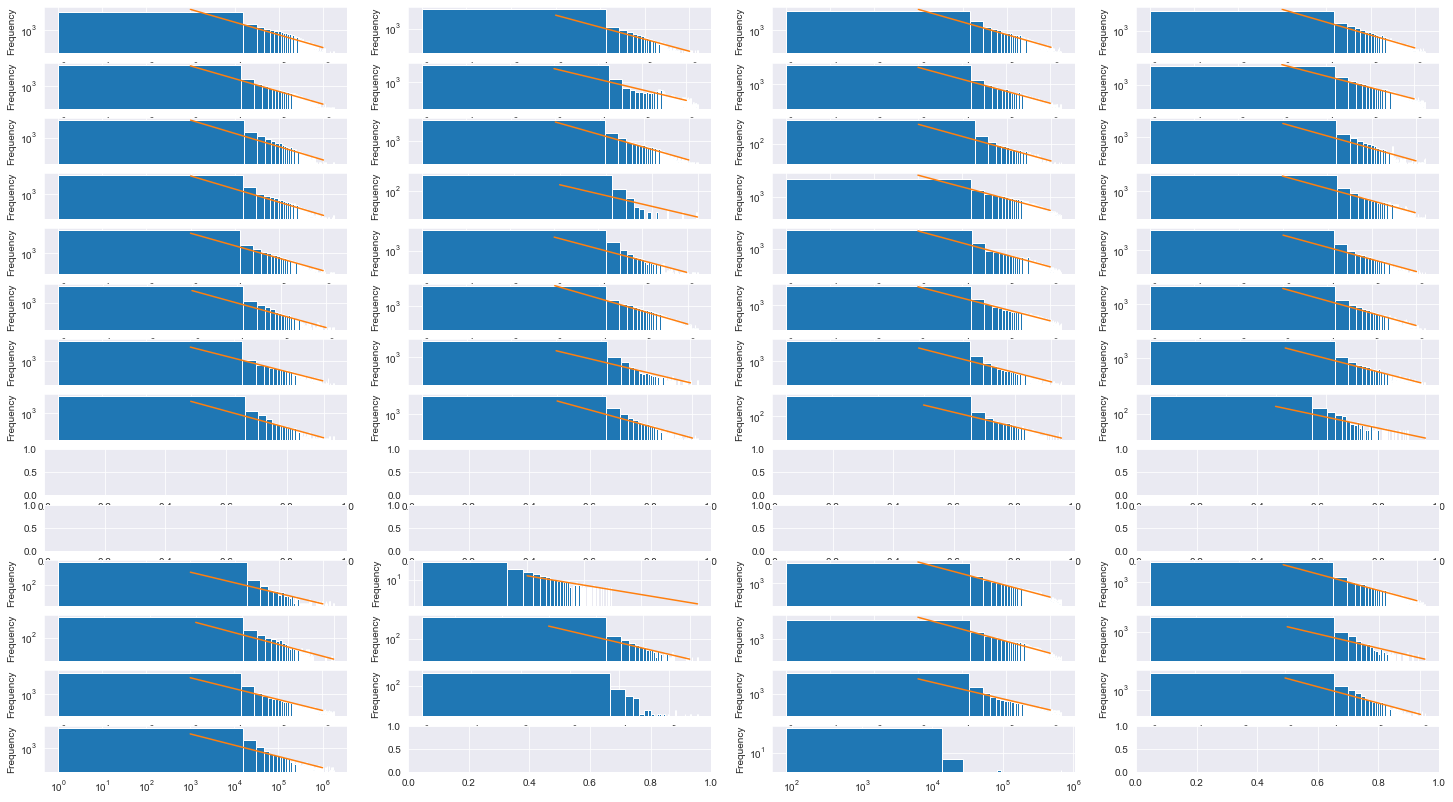

Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.001 : n_taps = 356386/356386/356386, computing ... n_bins = 111, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.002 : n_taps = 469340/469340/469340, computing ... n_bins = 113, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.003 : n_taps = 693077/693077/693077, computing ... n_bins = 117, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.004 : n_taps = 855750/855750/855750, computing ... n_bins = 119, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.005 : n_taps = 1797797/1797797/1797797, computing ... n_bins = 125, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.006 : n_taps = 158875/158875/158875, computing ... n_bins = 104, plotting ...
Participant ./3.decrypted/izedAa85XXrDS85XlwrOsIDU/moht.dsth.007 : n_taps = 512214/512214/512214, computing ... n_bins = 114, plotting ...
Participant ./3.decrypte

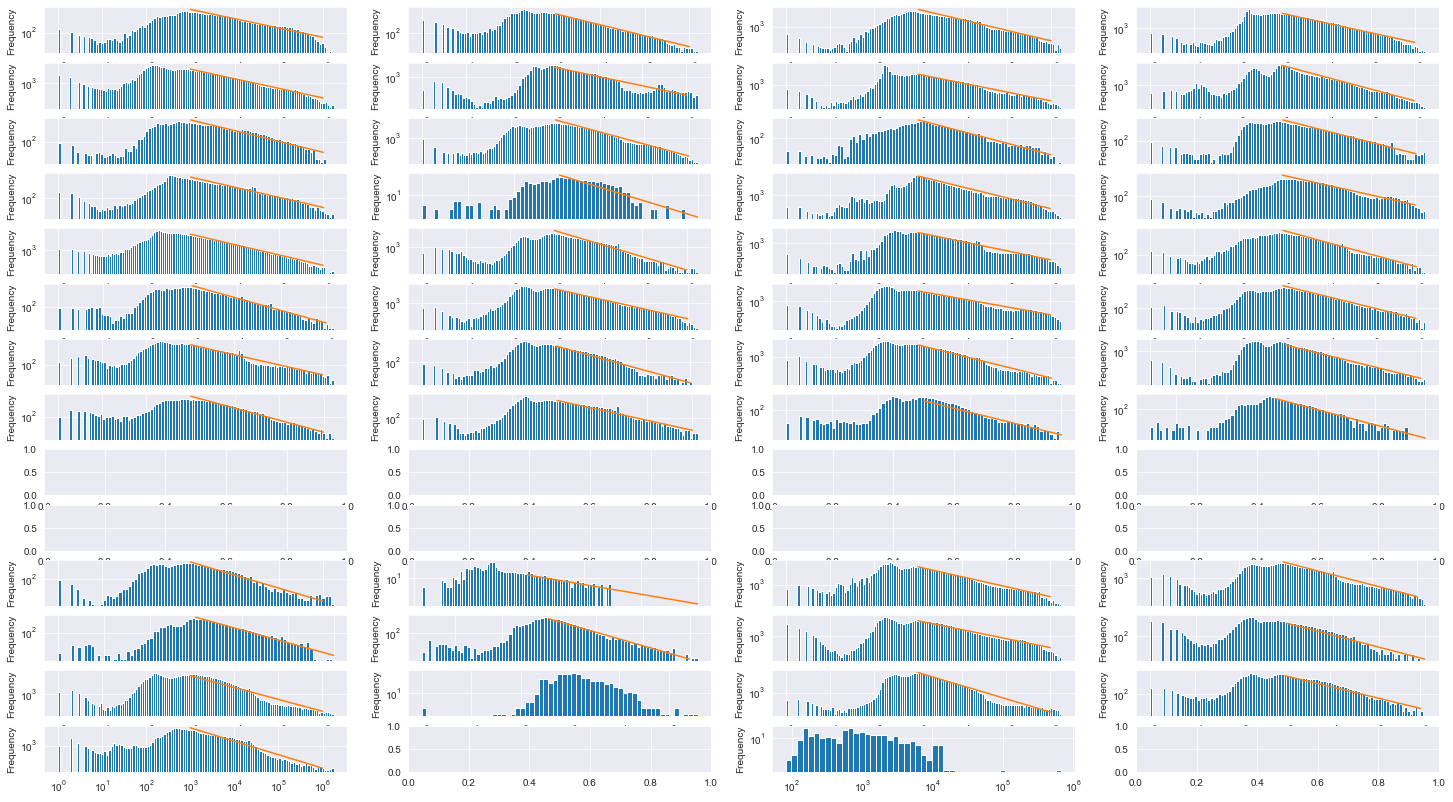

In [80]:
dd_apcls1 = widgets.Dropdown(options=['all', 'android system', 'social messenger', 'social media', 'entertainment', 'map navigation', 'utility tools', 'games'],
                 value='all', description='App Class')
dd_start_date1 = widgets.DatePicker(description='Start Date')
dd_end_date1 = widgets.DatePicker(description='End Date')
dd_plots1 = widgets.Dropdown(options=['direct (X, Y)', 'direct (logX, logY)', 'log uniform X (logY)'],
                            value='direct (logX, logY)', style={'description_width': '100px'}, description='Histogram Type')

def drawAll(e):
    userpaths = sorted([ROOTPATH+'/'+study+'/'+u for study in studies for u in os.listdir(ROOTPATH+'/'+study) if os.path.isdir(ROOTPATH+'/'+study+'/'+u)])
    ncol = 4
    nrow = int(np.ceil(len(userpaths)/4))
    W = 25
    H = W*(9/16)
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=[W,H*nrow])
    for ii, userpath in enumerate(userpaths):
        print('Participant %s : '%re.sub('@.*', '', userpath), end='', flush=True)
        drawOne(userpath, dd_plots1.value, 'auto', dd_apcls1.value, dd_start_date1.value, dd_end_date1.value, ax=axs[ii//4, ii%4], figsize=[W,H])
        if axs[ii//4, ii%4].get_legend() != None:
            axs[ii//4, ii%4].get_legend().remove()
    display(HTML("<font color='red'><B>%s</B></font>"%('App-class = %s'%dd_apcls1.value)))
button = widgets.Button(description='Draw All', style={'font_weight': 'bold'})
button.on_click(drawAll)
HBox([dd_apcls1, dd_plots1, dd_start_date1, dd_end_date1, button])

# Testing

In [ ]:
def show0(e):
    userpaths = sorted([ROOTPATH+'/'+study+'/'+u for study in studies for u in os.listdir(ROOTPATH+'/'+study) if os.path.isdir(ROOTPATH+'/'+study+'/'+u)])
    for ii, userpath in enumerate(userpaths):
        os.aa = df_taps = load_df(userpath+'/tapsLog.csv.gz', '', -1).copy()
        if len(df_taps.index)==0: continue
        df_cnt = df_taps['tz'].groupby(pd.Grouper(freq='D')).count()
        N_days = (df_taps.index.max()-df_taps.index.min())/pd.to_timedelta('1D')
        N_taps = len(df_taps.index)
        if N_days>0:
            print(os.path.basename(userpath), 'total_taps=%d, total_days=%d, taps_per_day=%f (max=%s, min=%s, std=%s)'%\
                  (N_taps, N_days, N_taps/N_days, df_cnt.max(), df_cnt.min(), df_cnt.std()))
#             print(df_taps['in_app_class'].value_counts())
            
        
button0 = widgets.Button(description='Show', style={'font_weight': 'bold'})
button0.on_click(show0)
HBox([button0])